This notebook will largely be a copy of `2015-03-26 Numerical Results for RTS-96`, but will use the correct line temperature model.

In [1]:
####### IMPORTS ########
include("../src/tmp_inst_rts96.jl")
include("../src/TemporalInstanton.jl")
include("../src/TemporalInstanton2.jl")
include("../src/LineThermalModel.jl")

using TemporalInstanton,TemporalInstanton2
using HDF5, JLD

####### LOAD DATA ########
psData = psDataLoad()

# unpack psDL (boilerplate):
(Sb,f,t,r,x,b,Y,bustype,
Gp,Gq,Dp,Dq,Rp,Rq,
Pmax,Pmin,Qmax,Qmin,Plim,
Vg,Vceiling,Vfloor,
busIdx,N,Nr,Ng,k) = unpack_psDL(psData)

Sb = 100e6 #overwrite "100.0"

res = r
reac = x

####### LINK DATA ########
# Static
Ridx = find(Rp) # Vector of renewable nodes
Y = full(Y) # Full admittance matrix (ref not removed)
ref = 1 # Index of ref node
k = k # Conventional generator participation factors
tau = 0.5 # Heating constant
G0 = [Gp,Gp,Gp]
D0 = [Dp,Dp,Dp]
P0 = [0.5.*Rp,Rp,1.5*Rp]
kQobj = 0 # Should always be zero; objective has no constant term
lines = [(f[i],t[i]) for i in 1:length(f)];
line_lengths = load("../data/RTS-96\ Data/line_lengths.jld", "line_lengths")

# Thermal model parameters:
Tamb = 35. # C
T0 = 46. # initial line steady-state temp
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps
int_length = 600. # seconds

n = size(Y,1)
nr = length(Ridx)
T = int(length(G0)/n) # infer number of time steps

# Create Qobj:
Qobj = tmp_inst_Qobj(n,nr,T)
# Augment Qobj with additional rows and columns of zeros:
Qobj = tmp_inst_pad_Q(full(Qobj),T)

# Create A1 (only A2 changes during opt.):
A1 = full(tmp_inst_A(Ridx,T,Y,ref,k))
A1 = [A1 zeros((n+1)*T,T)]

# Create b:
b = tmp_inst_b(n,T,G0,P0,D0)
# Augment b with new elements:
tmp_inst_pad_b(b,T)

# Create Qtheta:
Qtheta = tmp_inst_Qtheta(n,nr,T)#,tau)

# Form objective quadratic:
G_of_x = (Qobj,0,kQobj)

println("loaded")

loaded


In [2]:
score,x,θ,α,diffs,xopt = loop_through_lines_new(
    G_of_x,Qtheta,A1,b,
    n,T,Ridx,Sb,ref,lines,res,reac,line_lengths,Tamb,T0,int_length)
println("Unsolved lines: $(sum(score.==Inf))")

Unsolved lines: 0


In [20]:
#for idx = 1:length(f)
kQtheta = Float64[]
idx = 1
Sb = 100e6
for idx = 1:120
    if line_lengths[idx] == 0
        continue
    end
    line_model = LineModel(f[idx],
                t[idx],
                res[idx],
                reac[idx],
                line_lengths[idx],
                NaN,
                NaN,
                NaN,
                NaN,
                NaN,
                NaN,
                NaN,
                NaN)

    add_thermal_parameters(line_model, "waxwing")

    therm_a = compute_a(line_model.mCp,
                        line_model.ηc,
                        line_model.ηr,
                        Tamb,
                        line_model.Tlim)
    therm_c = compute_c(line_model.mCp,
                        line_model.rij,
                        line_model.xij,
                        Sb,
                        line_model.length)
    therm_d = compute_d(line_model.mCp,
                        line_model.ηc,
                        line_model.ηr,
                        Tamb,
                        line_model.Tlim,
                        line_model.qs)
    therm_f = compute_f(int_length,
                        therm_a,
                        therm_d,
                        time_intervals,
                        T0)
    # Temperature model
    push!(kQtheta,  (therm_a/therm_c)*(line_model.Tlim - therm_f))
    #Q_of_x = (Qtheta,0,kQtheta)
end

sort(kQtheta)

104-element Array{Float64,1}:
 -0.0661611  
 -0.0634922  
 -0.0634922  
 -0.0634922  
 -0.0580208  
 -0.0580208  
 -0.0580208  
 -0.0580208  
 -0.0491713  
 -0.0491713  
 -0.0491713  
 -0.0455978  
 -0.0455978  
  ⋮          
 -0.00267277 
 -0.00267277 
 -0.00267277 
 -0.00191512 
 -0.00191512 
 -0.00191512 
 -0.00108236 
 -0.00108236 
 -0.00108236 
 -0.000216473
 -0.000216473
 -0.000216473

In [93]:
using Interact
using PyPlot
PyPlot.svg(true)

true

Interpret results: is the line heating to the desired temperature? YES!!

Slider{Int64}([Input{Int64}] 52,"eidx",52,1:104)

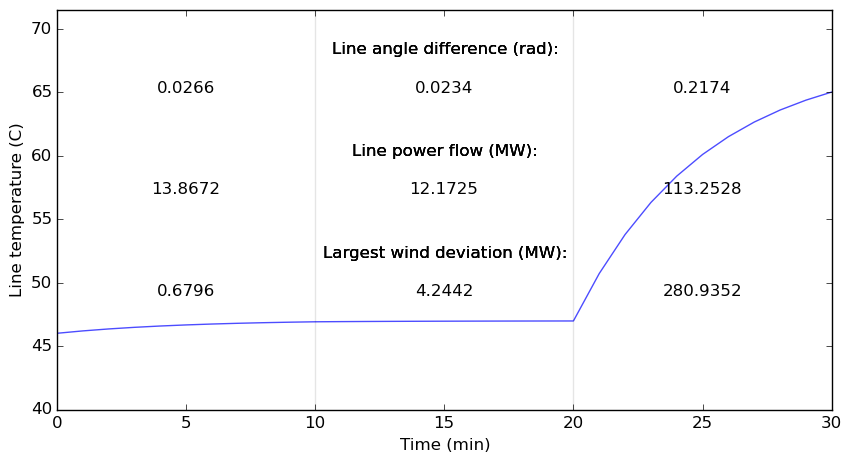

In [144]:
# choose an event index (1 is the instanton):
temp_eq(t,T0,a,b) = (T0 + b/therm_a).*exp(therm_a*t) - b/a # solution to approx. heat balance IVP
Tlim = 65.
ηc = 0.955
ηr = 2.207e-9
qs = 14.4
mCp = 383.
Tmid = (Tamb + Tlim)/2
therm_a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3)


fig = figure(figsize=(10,5))
@manipulate for eidx in 1:length(score); withfig(fig) do
        idx = find(score.==sort(score)[eidx])[1]
        from,to = lines[line_lengths.!=0][idx]
        r_ij = res[line_lengths.!=0][idx]
        x_ij = reac[line_lengths.!=0][idx]
        L_ij = line_lengths[line_lengths.!=0][idx]
        T0 = 46.

        angle_diffs = Float64[]
        for angles in θ[idx]
            push!(angle_diffs,angles[from] - angles[to])
        end

        # Tool to compute line temperature given initial temp and angle diffs:

        temp_values = [T0]
        power_flow = Float64[]
        
        for θij in angle_diffs
            f_loss_pu = r_ij*(θij/x_ij)^2 # pu
            f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
            push!(power_flow,(Sb/1e6)*θij/x_ij)
            b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
            temp_values = [temp_values,temp_eq(time_values,T0,therm_a,b)[2:end]]
            T0 = temp_values[end]
        end
        
        plot(temp_values,alpha=0.7)
        xlabel("Time (min)")
        ylabel("Line temperature (C)")
        axis([0,30,40,1.1*Tlim])
        plot([10,10],[40,1.1*Tlim],"k",alpha=0.1)
        plot([20,20],[40,1.1*Tlim],"k",alpha=0.1)
        midpoints = [5,15,25]
        vrules = [Tlim+3,Tlim-5,Tlim-13]
        for i in 1:T
            text(15,vrules[1],"Line angle difference (rad):",
                horizontalalignment="center")
            text(midpoints[i],vrules[1]-3,string(round(angle_diffs[i],4)),
                horizontalalignment="center")
            text(15,vrules[2],"Line power flow (MW):",
                horizontalalignment="center")
            text(midpoints[i],vrules[2]-3,string(round(power_flow[i],4)),
                horizontalalignment="center")
            
            largest_dev = maxabs(x[idx][i])
            text(15,vrules[3],"Largest wind deviation (MW):",
                horizontalalignment="center")
            text(midpoints[i],vrules[3]-3,string(round(largest_dev*Sb/1e6,4)),
                horizontalalignment="center")
        end
    end
end